# Tugas Prapraktikum

Tugas Prapraktikum dikerjakan dengan _dataset_ [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/download?datasetVersionNumber=2). Tanpa meninjau waktu (`date`), prediksi status hujan pada keesokan harinya (`RainTomorrow`). Berikan nilai `1` jika diprediksi hujan pada keesokan harinya, `0` jika tidak.

<br>
Tugas dikerjakan secara berkelompok. Setiap kelompok terdiri atas 2 (dua) mahasiswa. Kumpulkan paling lambat pada Minggu, 16 April 2023, pukul 23:59 WIB melalui Edunex.

# 0. Persiapan Data and Pustaka

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0
!pip install thundersvm
!pip install thundersvm-cpu

In [ ]:
# Letakkan pustaka di sini.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier

# from thundersvm import SVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

In [ ]:
# Baca data di sini.
# df = pd.read_csv("weatherAUS.csv")
df = pd.read_csv("https://raw.githubusercontent.com/gchoi/Dataset/master/weatherAUS.csv")
print(df.head())

        Date      Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  5/18/2009        Hobart      5.1     14.3       0.0          1.8       8.9   
1   7/3/2009    Launceston      1.1     14.5       0.4          NaN       NaN   
2  2/18/2010   Williamtown     19.7     26.2       0.0          7.2       7.2   
3   3/4/2010  PerthAirport     16.6     28.0       0.0          9.0      11.3   
4   9/9/2010     GoldCoast     14.6     25.3       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0          NW           30.0        WSW  ...        47.0       1023.1   
1         SSW           50.0          E  ...        46.0       1001.5   
2         SSE           41.0        SSE  ...        50.0       1020.9   
3          SW           54.0        SSE  ...        41.0       1018.3   
4         NNW           43.0        WNW  ...        67.0       1020.3   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_MM  

# I. Pemahaman Data
Tujuan dari bagian ini adalah peserta dapat memahami kualitas dari data yang diberikan. Hal yang diliputi adalah sebagai berikut:
1. Ukuran data
2. Statistik dari tiap fitur
3. Pencilan (_outlier_)
4. Korelasi
5. Distribusi 

## I.1 
Carilah:
1. Ukuran dari data (instansi dan fitur)
2. Tipe dari setiap fitur 
3. Banyak nilai unik dari fitur yang bertipe kategorikal
4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal

In [ ]:
# I.1 Kode di sini.

# 1. Ukuran Data
print("1. Ukuran Data")
print("Jumlah Instance: ", df.shape[0])
print("Jumlah Fitur   : ", df.shape[1])
print("")

# 2. Tipe dari setiap fitur
print("2. Tipe dari setiap fitur")
print(df.dtypes)
print("")

# 3. Banyaknya nilai unique dari fitur yang bertipe kategorikal
print("3. Banyaknya nilai unique dari fitur yang bertipe kategorikal")
for i in range(len(df.columns)):
    #Cek apakah tipe data adalah kategorikal (object)
    if df.dtypes[i] == "object":
        print(df.columns[i], ":", df[df.columns[i]].nunique())
print("")

# 4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur non-kategorikal
print("4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur non-kategorikal")
print(df.describe())
print("")


1. Ukuran Data
Jumlah Instance:  36881
Jumlah Fitur   :  24

2. Tipe dari setiap fitur
Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RISK_MM          float64
RainTomorrow      object
dtype: object

3. Banyaknya nilai unique dari fitur yang bertipe kategorikal
Date : 1473
Location : 46
WindGustDir : 16
WindDir9am : 16
WindDir3pm : 16
RainToday : 2
RainTomorrow : 2

4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur non-kategorikal
            MinTemp       MaxTemp  

## I.2
Carilah:
1. Nilai hilang (_missing_) dari setiap fitur
2. Nilai pencilan (_outlier_) dari setiap fitur

In [ ]:
# I.2 Kode di sini.
# 1. Nilai hilang (missing) dari setiap fitur
print("1. Nilai hilang (missing) dari setiap fitur")
print(df.isnull().sum())
print("")

# 2. Nilai pencilan (outlier) dari setiap fitur
print("2. Nilai pencilan (outlier) dari setiap fitur")
for i in range(len(df.columns)):
    #Cek apakah tipe data adalah non-kategorikal
    if df.dtypes[i] != "object":
        currentColumn = df[df.columns[i]]
        Q1 = currentColumn.quantile(0.25)
        Q3 = currentColumn.quantile(0.75)
        IQR = Q3 - Q1
        pencilanBawah = Q1 - 1.5 * IQR
        pencilanAtas = Q3 + 1.5 * IQR
        print(df.columns[i], ":", currentColumn[(currentColumn < pencilanBawah) | (currentColumn > pencilanAtas)].count())

1. Nilai hilang (missing) dari setiap fitur
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64

2. Nilai pencilan (outlier) dari setiap fitur
MinTemp : 8
MaxTemp : 109
Rainfall : 6792
Evaporation : 954
Sunshine : 0
WindGustDir : 0
WindGustSpeed : 751
WindDir9am : 0
WindDir3pm : 0
WindSpeed9am : 367
WindSpeed3pm : 609
Humidity9am : 400
Humidity3pm : 0
Pressure9am : 370
Pressure3pm : 347
Cloud9am : 0
Cloud3pm : 0
Temp9am : 60
Temp3pm : 182
RainToday : 8407
RISK_MM : 6728
RainTomorrow : 8368


## I.3
Lakukan:
1. Pencarian korelasi antarfitur
2. Visualisasi distribusi setiap fitur (kategorikal dan kontinu)
3. Visualisasi distribusi setiap fitur per target (`RainTomorrow`)

1. Pencarian korelasi antar fitur
                MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
MinTemp        1.000000  0.745450  0.114714     0.514247  0.046233   
MaxTemp        0.745450  1.000000 -0.058451     0.632326  0.445373   
Rainfall       0.114714 -0.058451  1.000000    -0.065744 -0.229616   
Evaporation    0.514247  0.632326 -0.065744     1.000000  0.344674   
Sunshine       0.046233  0.445373 -0.229616     0.344674  1.000000   
WindGustSpeed  0.185390  0.073319  0.127205     0.220562 -0.035211   
WindSpeed9am   0.169488  0.002626  0.082290     0.186000 -0.010571   
WindSpeed3pm   0.175644  0.046446  0.055642     0.125331  0.040855   
Humidity9am   -0.212781 -0.477478  0.234658    -0.531779 -0.498088   
Humidity3pm    0.036832 -0.469851  0.256748    -0.388799 -0.639121   
Pressure9am   -0.427758 -0.308608 -0.167669    -0.280160  0.059687   
Pressure3pm   -0.434029 -0.394379 -0.128309    -0.301839  0.004013   
Cloud9am       0.135306 -0.256593  0.210986    -0.183448

<ipython-input-6-564d2bf32586>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


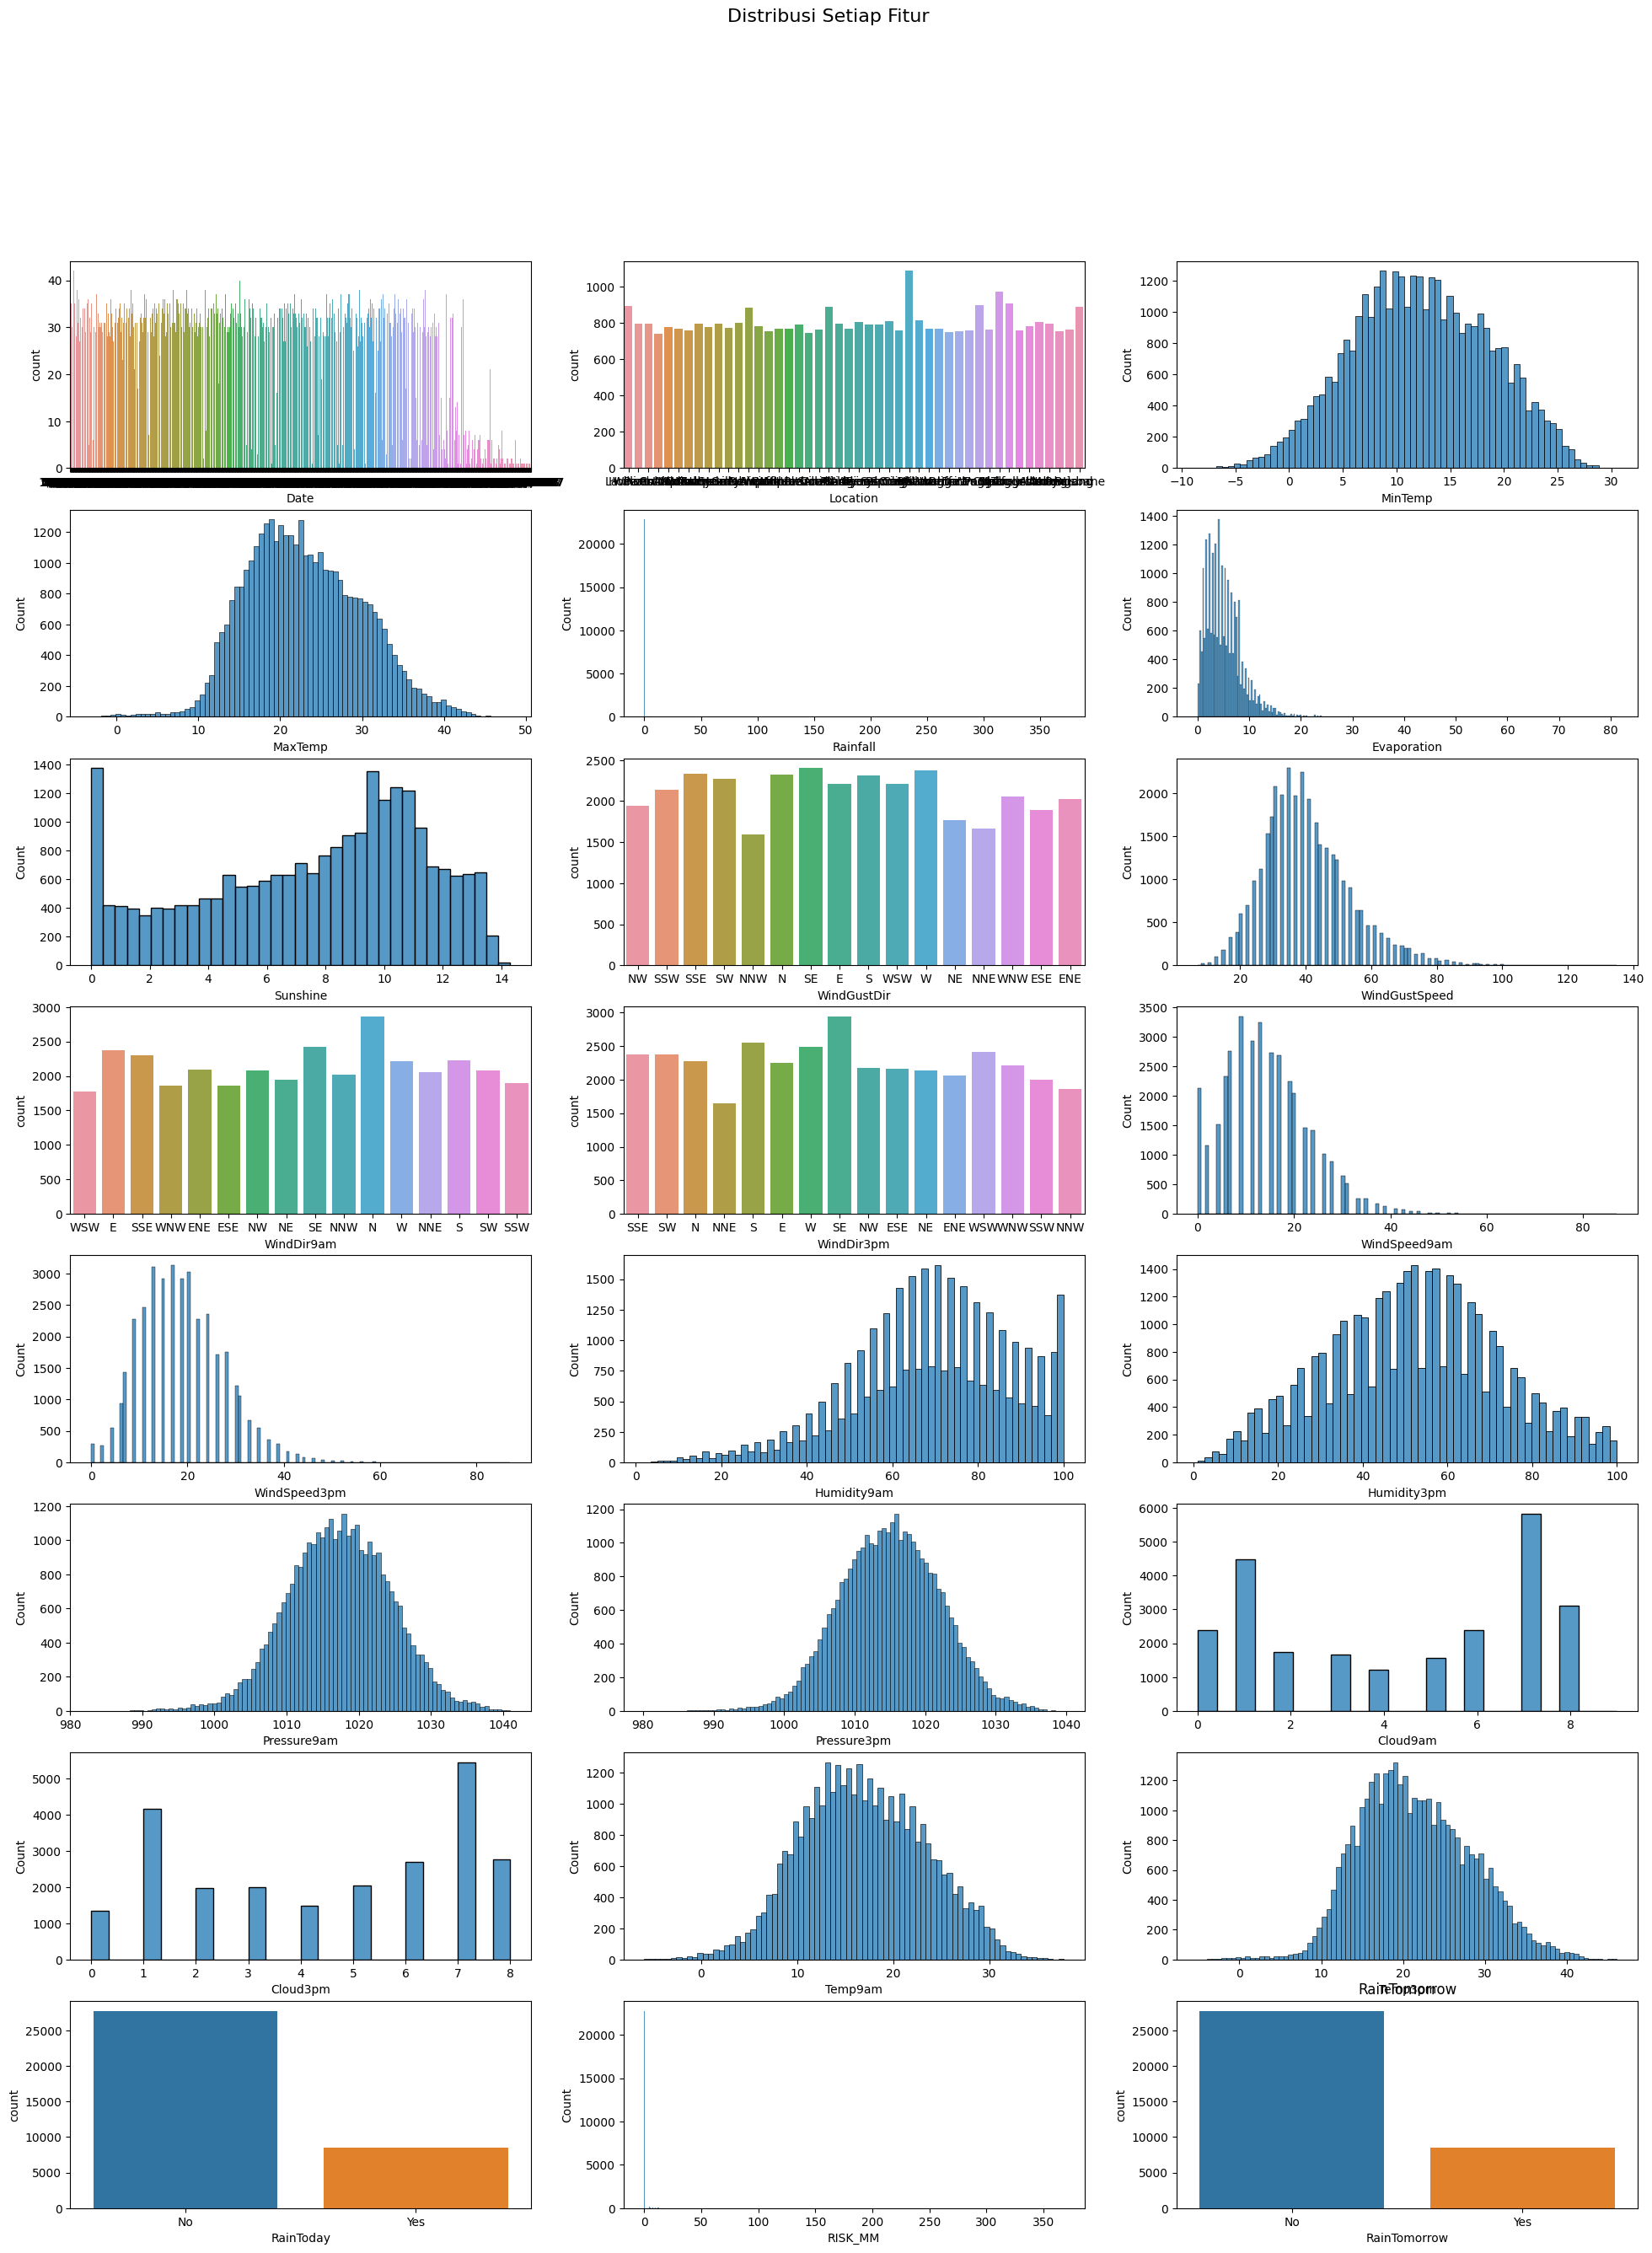

3. Visualisasi distribusi setiap fitur per target (`RainTomorrow`)


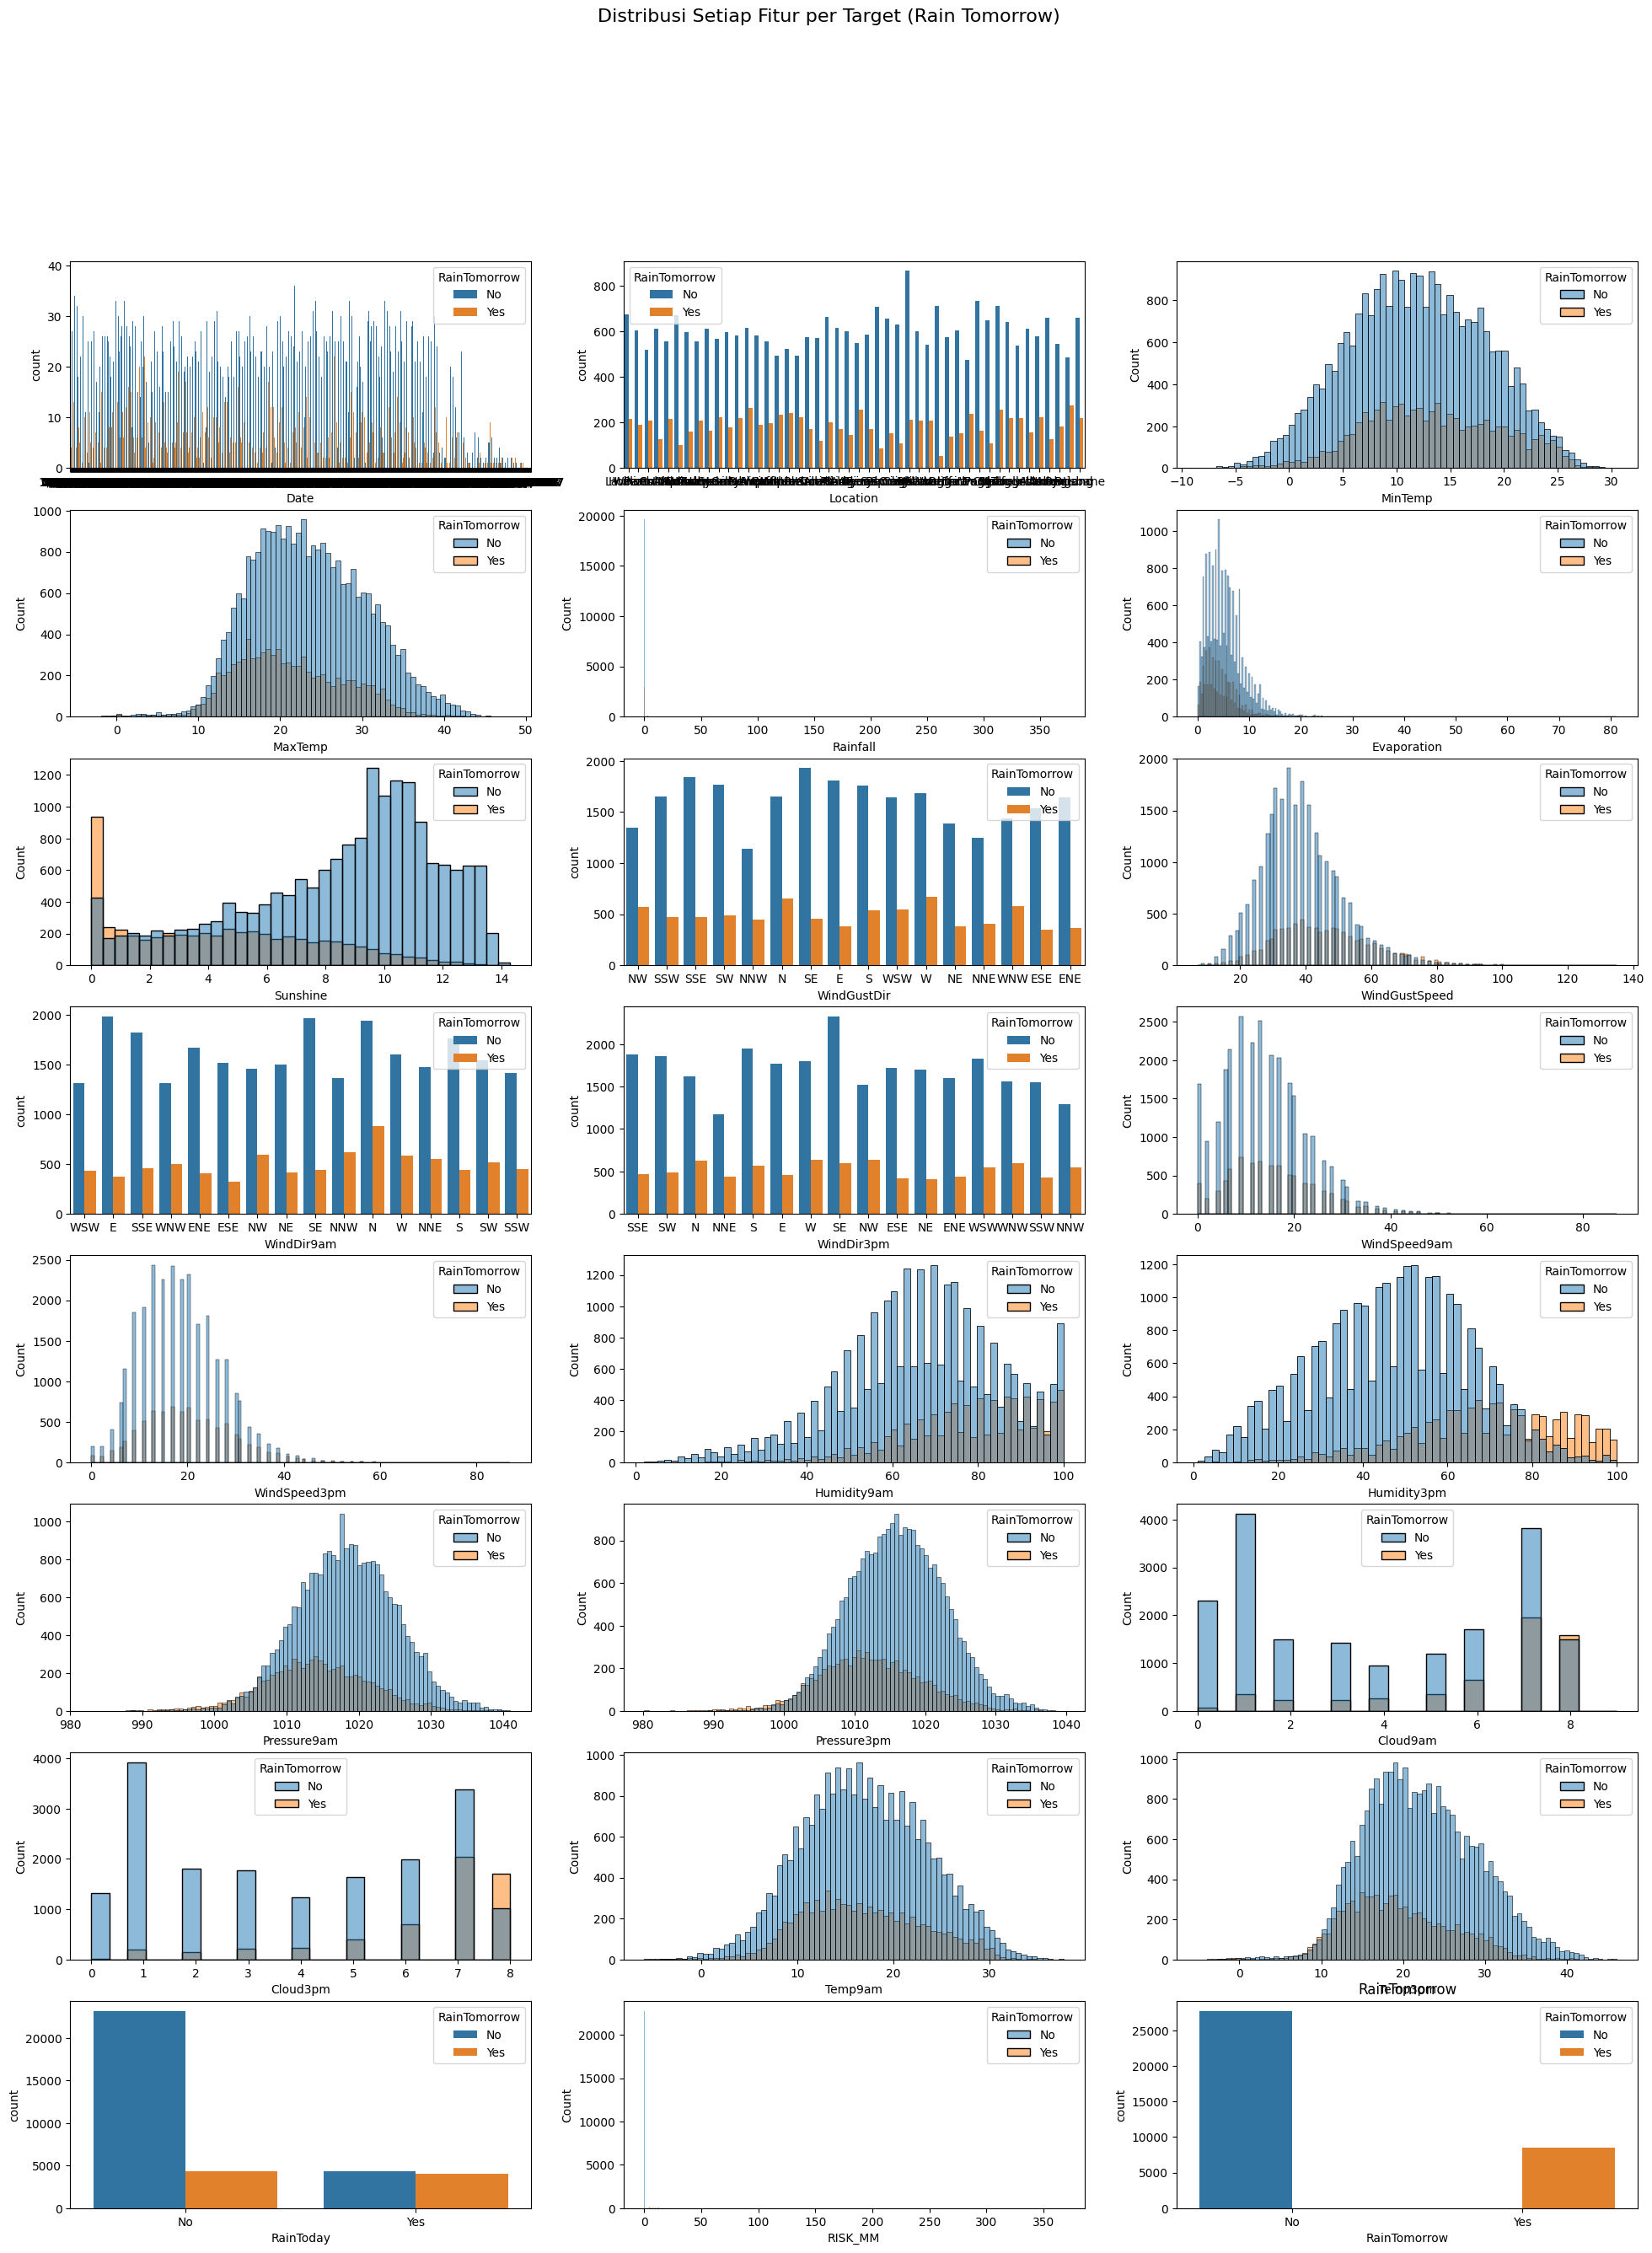

In [ ]:
# I.3 Kode di sini.

# 1. Pencarian korelasi antar fitur
print("1. Pencarian korelasi antar fitur")
print(df.corr())
print("")

# 2. Visualisasi distribusi setiap fitur (kategorikal dan kontinu)
print("2. Visualisasi distribusi setiap fitur (kategorikal dan kontinu)")
#Create Subplots
fig, axes = plt.subplots(8, 3, figsize=(24, 30))
#Title of the figure
fig.suptitle('Distribusi Setiap Fitur', fontsize=16)
for i in range(len(df.columns)):
    #Cek apakah tipe data adalah kategorikal (object)
    if df.dtypes[i] == "object":
        sns.countplot(data=df, x=df.columns[i], ax=axes[i//3, i%3])
        plt.title(df.columns[i])

    #Jika tipe data bukan kategorikal (kontinu)
    else:
        sns.histplot(data=df, x=df.columns[i], ax=axes[i//3, i%3])
        plt.title(df.columns[i])
plt.show()

# 3. Visualisasi distribusi setiap fitur per target (`RainTomorrow`)
print("3. Visualisasi distribusi setiap fitur per target (`RainTomorrow`)")
#Create Subplots
fig, axes = plt.subplots(8, 3, figsize=(24, 30))
#Title of the figure
fig.suptitle('Distribusi Setiap Fitur per Target (Rain Tomorrow)', fontsize=16)
for i in range(len(df.columns)):
    #Cek apakah tipe data adalah kategorikal (object)
    if df.dtypes[i] == "object":
        sns.countplot(data=df, x=df.columns[i] , hue="RainTomorrow", ax=axes[i//3, i%3])
        plt.title(df.columns[i])

    #Jika tipe data bukan kategorikal (kontinu)
    else:
        sns.histplot(data=df, x=df.columns[i], hue="RainTomorrow", ax=axes[i//3, i%3])
        plt.title(df.columns[i])
plt.show()

## I.4
Lakukanlah analisis lebih lanjut jika diperlukan, kemudian lakukan hal berikut:
1. Penambahan fitur jika memungkinkan
2. Pembuangan fitur yang menurut kalian tidak dibutuhkan
3. Penanganan nilai hilang
4. Transformasi data kategorikal menjadi numerikal (_encoding_)
5. _Scaling_ dengan `MinMaxScaler`

In [ ]:
# I.4 Put your code here
#Sementara biar data selalu di load

# 1. Penambahan fitur jika memungkinkan
print("1. Penambahan fitur jika memungkinkan")
print("Tidak ada fitur yang ditambahkan")


# # 2. Pembuangan fitur yang menurut kalian tidak dibutuhkan
print("2. Pembuangan fitur yang menurut kalian tidak dibutuhkan")
df = df.drop(columns=["Date","Location"])
print(df.head())


# 3. Penanganan nilai hilang
print("3. Penanganan nilai hilang")
#Hapus Data yang tidak ada data Tujuan (RainToday atau RainTomorrow)
df = df.dropna(subset=["RainToday", "RainTomorrow"])
# Interpolasi untuk fitur yang bertipe kontinu
df.interpolate(method="linear", limit_direction="both", inplace=True)
# Karena hanya data arah angin yang masih kosong, isi dengan tidak ada arah angin
df["WindGustDir"].fillna("NO", inplace=True)
df["WindDir9am"].fillna("NO", inplace=True)
df["WindDir3pm"].fillna("NO", inplace=True)
#Cek Apakah masih ada data yang kosong
print(df.isnull().sum())


# 4. Transformasi data kategorikal menjadi numerikal (_encoding_)
print("4. Transformasi data kategorikal menjadi numerikal (_encoding_)")
#Encode data kategorikal
le = LabelEncoder()
for i in range(len(df.columns)):
    #Cek apakah tipe data adalah kategorikal (object)
    if df.dtypes[i] == "object":
        df[df.columns[i]] = le.fit_transform(df[df.columns[i]])
print(df.head())

# 5. _Scaling_ dengan `MinMaxScaler`
print("5. _Scaling_ dengan `MinMaxScaler`")
#Scaling data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(df.head())


1. Penambahan fitur jika memungkinkan
Tidak ada fitur yang ditambahkan
2. Pembuangan fitur yang menurut kalian tidak dibutuhkan
   MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0      5.1     14.3       0.0          1.8       8.9          NW   
1      1.1     14.5       0.4          NaN       NaN         SSW   
2     19.7     26.2       0.0          7.2       7.2         SSE   
3     16.6     28.0       0.0          9.0      11.3          SW   
4     14.6     25.3       0.0          NaN       NaN         NNW   

   WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
0           30.0        WSW        SSE           7.0  ...         47.0   
1           50.0          E         SW           7.0  ...         46.0   
2           41.0        SSE        SSE          19.0  ...         50.0   
3           54.0        SSE         SW          28.0  ...         41.0   
4           43.0        WNW          N           6.0  ...         67.0   

   Pressure9am  Pr

# II. Desain Eksperimen
Tujuan dari bagian ini adalah peserta dapat memahami cara melakukan eksperimen mencari metode terbaik dengan benar. Hal yang diliputi adalah sebagai berikut:
1. Pembuatan model
2. Proses validasi
3. _Hyperparameter tuning_

## II.1
Tentukanlah metrik yang akan digunakan pada eksperimen kali ini. Metrik yang dapat lebih dari satu jenis.

(Tuliskan jawaban bagian II.1 di sini.)
Metrik yang digunakan pada eksperimen kali ini adalah:
1. Accuracy
2. Precission
3. Recall
4. F1 Score
5. AUROC

## II.2 
Bagi data dengan perbandingan 0,8 untuk data latih dan 0,2 untuk data validasi.

In [ ]:
# II.2 Kode di sini

# Membagi data menjadi data latih (80%) dan data validasi (20%)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["RainTomorrow"]), df["RainTomorrow"], test_size=0.2, random_state=0)

## II.3
Lakukan hal berikut:
1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.
2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
3. Tampilkan _confusion matrix_.

In [ ]:
# II.3 Kode di sini

def baseline(X_train, y_train, X_test, y_test):
  # 1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.
  print("1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.")
  #Membuat model
  model = LogisticRegression()
  #Melatih model
  model.fit(X_train, y_train)
  #Memprediksi data
  y_pred = model.predict(X_test)
  print("")

  # 2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
  print("2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1")
  print("Accuracy :", accuracy_score(y_test, y_pred))
  print("Precision :", precision_score(y_test, y_pred))
  print("Recall :", recall_score(y_test, y_pred))
  print("F1 :", f1_score(y_test, y_pred))
  print("AUROC :", roc_auc_score(y_test, y_pred))
  print("")


  # 3. Tampilkan _confusion matrix_.
  print("3. Tampilkan _confusion matrix_.")
  #Membuat confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  #Menampilkan confusion matrix
  print(cm)

baseline(X_train, y_train, X_test, y_test)

1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.

2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
Accuracy : 0.8769316441598218
Precision : 0.8493723849372385
Recall : 0.5904595695171612
F1 : 0.696636925188744
AUROC : 0.7787583352710257

3. Tampilkan _confusion matrix_.
[[5284  180]
 [ 704 1015]]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## II.4 
Lakukanlah:
1. Pembelajaran dengan model lain
2. _Hyperparameter tuning_ untuk model yang dipakai dengan menggunakan _grid search_ (perhatikan _random factor_ pada beberapa algoritma model)
3. Validasi dengan _cross validation_


In [ ]:
# II.4 Kode di sini.
# 1. Pembelajaran dengan model lain
print("1. Pembelajaran dengan model lain")
#Membuat model
model = SVC(kernel="rbf", random_state=0)
#Melatih model
model.fit(X_train, y_train)
#Memprediksi data
y_pred = model.predict(X_test)
#menampilkan hasil
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision, Recall, F1:", classification_report(y_test, y_pred))
print("AUROC :", roc_auc_score(y_test, y_pred))
print("")


# 2. _Hyperparameter tuning_ untuk model yang dipakai dengan menggunakan _grid search_ (perhatikan _random factor_ pada beberapa algoritma model)
print("2. _Hyperparameter tuning_ untuk model yang dipakai dengan menggunakan _grid search_ (perhatikan _random factor_ pada beberapa algoritma model)")
#Membuat model
model = SVC(kernel="rbf", random_state=0)
#Membuat parameter
param = {"C": [0.1, 1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001, 0.0001], "kernel": ["rbf"]}
#Membuat grid search
grid = GridSearchCV(model, param, refit=True, verbose=3)
#Melatih model
grid.fit(X_train, y_train)
#Menampilkan hasil terbaik
print(grid.best_params_)
print(grid.best_estimator_)
#Menampilkan hasil prediksi
grid_predictions = grid.predict(X_test)
print("Accuracy :", accuracy_score(y_test, grid_predictions))
print("Precision, Recall, F1:", classification_report(y_test, grid_predictions))
print("AUROC :", roc_auc_score(y_test, grid_predictions))
print("")

# 3. Validasi dengan _cross validation_
print("3. Validasi dengan _cross validation_")
cv = cross_val_score(model, X_train, y_train, cv=5)
print("Akurasi :", cv)
print("Rata-rata akurasi :", cv.mean())
print("")

1. Pembelajaran dengan model lain
Accuracy : 0.8531254350549909
Precision, Recall, F1:               precision    recall  f1-score   support

         0.0       0.85      0.97      0.91      5464
         1.0       0.85      0.47      0.60      1719

    accuracy                           0.85      7183
   macro avg       0.85      0.72      0.76      7183
weighted avg       0.85      0.85      0.84      7183

AUROC : 0.7206470487029385

2. _Hyperparameter tuning_ untuk model yang dipakai dengan menggunakan _grid search_ (perhatikan _random factor_ pada beberapa algoritma model)
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.838 total time=  15.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.839 total time=  18.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.838 total time=  17.8s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.840 total time=  16.3s
[CV 5/5] END ........C=0.1, 

In [ ]:
#{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
print("Model Terbaik :")
model = SVC(C=1000, gamma=0.1, kernel="rbf", random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision, Recall, F1:")
print(classification_report(y_test, y_pred))
print("AUROC :", roc_auc_score(y_test, y_pred))
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross Validation Score :" , scores)

Model Terbaik :
Accuracy : 0.9870527634693025
Precision, Recall, F1:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5464
         1.0       0.99      0.95      0.97      1719

    accuracy                           0.99      7183
   macro avg       0.99      0.98      0.98      7183
weighted avg       0.99      0.99      0.99      7183

AUROC : 0.9751423352131079
Cross Validation Score : [0.98433693 0.98659937 0.9841629  0.98625131 0.9848564 ]


# III. Improvement
Pada bagian ini, kalian diharapkan dapat:
1. melakukan pelatihan dengan data hasil _oversampling_ / _undersampling_, disertai dengan validasi yang benar; serta
2. menerapkan beberapa metode untuk menggabungkan beberapa model.

Kedua hal ini adalah contoh metode untuk meningkatkan kinerja dari model.

## III.1
Lakukanlah:
1. _Oversampling_ pada kelas minoritas pada data latih
2. _Undersampling_ pada kelas mayoritas pada data latih

Pada setiap tahap, latih dengan model *baseline* (II.3), dan validasi dengan data validasi. Data latih dan validasi adalah data yang disusun pada bagian II.2.

In [ ]:
# III.1 Kode di sini.

# Check distribusi
print("Distribusi (Kelas Minoritas Mayoritas)")
print(y_train.value_counts())

# Melakukan Over sampling
print("\nPART 1 Oversampling pada kelas minoritas pada data latih")
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)
print("\nData setelah oversampling")
print(sorted(Counter(y_train_ros).items()))

baseline(X_train_ros, y_train_ros, X_test, y_test)

# Melakukan undersampling
print("\nPART 2 Undersampling pada kelas mayoritas pada data latih")
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)
print("\nData setelah undersampling")
print(sorted(Counter(y_train_rus).items()))
baseline(X_train_rus, y_train_rus, X_test, y_test)

Distribusi (Kelas Minoritas Mayoritas)
0.0    22080
1.0     6649
Name: RainTomorrow, dtype: int64

PART 1 Oversampling pada kelas minoritas pada data latih

Data setelah oversampling
[(0.0, 22080), (1.0, 22080)]
1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
Accuracy : 0.8680217179451483
Precision : 0.6859623733719248
Recall : 0.8272251308900523
F1 : 0.75
AUROC : 0.8540408231317027

3. Tampilkan _confusion matrix_.
[[4813  651]
 [ 297 1422]]

PART 2 Undersampling pada kelas mayoritas pada data latih

Data setelah undersampling
[(0.0, 6649), (1.0, 6649)]
1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.

2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
Accuracy : 0.8322427954893499
Precision : 0.6131161971830986
Recall : 0.8103548574752764
F1 : 0.6980706589827113
AUROC : 0.8247418504067451

3. Tampilkan _confusion matrix_.
[[4585  879]
 [ 326 1393]]


## III.2
Lakukanlah:
1. Eksplorasi _soft voting_, _hard voting_, dan _stacking_.
2. Buatlah model _logistic regression_ dan SVM.
3. Lakukanlah _soft voting_ dari model-model yang dibangun pada poin 2.
4. Lakukan _hard voting_ dari model-model yang dibangun pada poin 2.
5. Lakukanlah _stacking_ dengan _final classifier_ adalah _logistic regression_ dari model-model yang dibangun pada poin 2.
6. Lakukan validasi dengan metrics yang telah ditentukan untuk poin 3, 4, dan 5.

(Tuliskan hasil eksplorasi III.2 poin 1 di sini.)

In [ ]:
# III.2 Kode di sini.
# Model Logreg dan SVM
print("2. Buatlah model logistic regression dan SVM.")
print("Model Logreg")
logregModel = LogisticRegression()

print("Model SVM")
svmModel = SVC(C=1000, gamma=0.1, kernel="rbf", random_state=0, probability=True)

print("\n3. Lakukanlah soft voting dari model-model yang dibangun pada poin 2")
softVoting = VotingClassifier(estimators=[('svm', svmModel), ('logreg', logregModel)], voting='soft')
softVoting.fit(X_train, y_train)

print("\n4. Lakukanlah hard voting dari model-model yang dibangun pada poin 2")
hardVoting = VotingClassifier(estimators=[('svm', svmModel), ('logreg', logregModel)], voting='hard')
hardVoting.fit(X_train, y_train)

print("\n5. Lakukanlah stacking dari model-model yang dibangun pada poin 2")
stacking = StackingClassifier(estimators=[('svm', svmModel), ('logreg', logregModel)], final_estimator=LogisticRegression())
stacking.fit(X_train, y_train)


print("\n6. Lakukan validasi dengan metrics yang telah ditentukan untuk poin 3, 4, dan 5.")

def validation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision, Recall, F1:")
    print(classification_report(y_test, y_pred))
    print("AUROC :", roc_auc_score(y_test, y_pred))

print("\nSoft Voting")
validation(softVoting, X_test, y_test)

print("\nHard Voting")
validation(hardVoting, X_test, y_test)

print("\nStacking")
validation(stacking, X_test, y_test)


2. Buatlah model logistic regression dan SVM.
Model Logreg
Model SVM

3. Lakukanlah soft voting dari model-model yang dibangun pada poin 2


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



4. Lakukanlah hard voting dari model-model yang dibangun pada poin 2


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



5. Lakukanlah stacking dari model-model yang dibangun pada poin 2


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che


6. Lakukan validasi dengan metrics yang telah ditentukan untuk poin 3, 4, dan 5.

Soft Voting
Accuracy : 0.9863566754837811
Precision, Recall, F1:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5464
         1.0       0.98      0.96      0.97      1719

    accuracy                           0.99      7183
   macro avg       0.98      0.98      0.98      7183
weighted avg       0.99      0.99      0.99      7183

AUROC : 0.9774758171738309

Hard Voting
Accuracy : 0.899902547682027
Precision, Recall, F1:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      5464
         1.0       0.99      0.59      0.74      1719

    accuracy                           0.90      7183
   macro avg       0.94      0.79      0.84      7183
weighted avg       0.91      0.90      0.89      7183

AUROC : 0.7924616528558178

Stacking
Accuracy : 0.9908116385911179
Precision, Recall, F1:
              pr

# IV. Analisis
Bandingkan hasil dari hal-hal berikut:
1. Model _baseline_ (II.3)
2. Model lain (II.4)
3. Hasil _undersampling_
4. Hasil _oversampling_
5. Hasil _soft voting_
6. Hasil _hard voting_
7. Hasil _stacking_

(Tuliskan jawaban bagian IV di sini.)

1. Pada model baseline, diperoleh hasil yang kurang memuaskan yakni dengan accuracy sebesar 87.7%, precision 84.9%, recall 59%, dan F1 score sebesar 69.7%. Hasil tersebut disebabkan oleh logistic regression yang tidak kunjung converge walau sudah melakukan iterasi sebanyak 100 kali. Hal terebut juga diperparah oleh encoding yang kurang optimal yakni dengan label encoding. Hal tersebut kurang tepat untuk digunakan pada data arah mata angin karena suatu marah mata angin tidak bernilai lebih dibanding yang lain. Namun kami tetap menggunakan hal tersebut karena one-hot encoding akan menghasilkan terlalu banyak fitur baru yakni 16 fitur baru untuk setiap fitur mata angin yang perlu diencode sehingga kami tetap memilih label encoding

2. Pada model lain, dipilih model SVM dengan kernel rbf. Awalnya hasil masih kurang memuaskan dengan accuracy 85%. Namun setelah melakukan grid search dengan parameter search pada C dan gamma, diperoleh model SVM yang sangat baik yakni SVM dengan C = 1000 dan gamma = 0.1. Model tersebut memiliki accuracy yang sangat baik yakni pada 98.7%. Hal tersebut diperoleh karena tuning parameter gamma, C dan kernel yang sudah baik.

3. Dengan Undersampling, didapat sebanyak 6649 data baik minority dan majority, hasil model setelah dilakukan Undersampling memiliki accuracy sebesar 83.2%,Precision 61.3%, Recall 81.0%, F1 Score sebesar 69.8%. Dengan baseline, terlihat bahwa Model setelah dilakukannya undersampling memiliki hasil yang lebih baik pada aspek recall yang juga memperbesar nilai F1 Score. Sedangkan terjadi tradeoff terhadap akurasi serta presisi. Model mampu mengklasifikasikan lebih baik dengan mengurangi dampak dari label target 0 yang berdampak pada Recall lebih baik. Secara keseluruhan dari nilai F1-Score, model ini menghasilkan klasifikasi yang lebih baik dari baseline.

4. Dengan Oversampling, didapat sebanyak 22080 data baik kelas minority dan majority, hasil model setelah dilakukan Oversampling memiliki Accuracy 86.8%,Precision 68.5%, Recall 82.7%, F1-Score 75%. Dengan baseline, terlihat bahwa seperti halnya dengan Undersampling adanya tradeoff antara Recall dengan Accuracy serta Precision. Namun, hasil model setelah dilakukan Oversampling ini memiliki hasil semua metrik lebih baik dari Undersampling dan keseluruhan lebih baik dari baseline berdasarkan F1-Score. Terlihat bahwa dampak penduplikasian atas data kelas 1 memperbaiki hasil model.

5. Soft Voting dengan gabungan model log reg dan SVM menghasilkan model dengan metrik Accuracy 98.6%, Precision 98%, Recall 98%, serta F1-Score 98%. Hal ini merupakan pengembangan siginifikan dari base model dan secara akurasi menyerupai dari SVC Best Param hasil Grid Search.

6. Hard Voting dengan gabungan model log reg dan SVM menghasilkan model dengan metrik Accuracy 89.8%, Precision 94%, Recall 79%, serta F1-Score 84%. Hal ini merupakan pengembangan dari base model meskipun menghasilkan model yang kurang baik dibandingkan dari Soft Voting, namun lebih baik dari Undersampling maupun Oversampling. Hard Voting memiliki kinerja yang kurang baik dibandingkan Soft Voting dengan keunggulan Soft Voting yang mempertimbangkan probabilitas probabilitas setiap kelas dari model (tidak hanya probabilitas tertinggi yang dilakukan Hard Voting).

7. Melakukan Stacking dari model log reg dan SVM dengan final predictor Log Regression, model yang dihasilkan memiliki nilai 99% untuk semua metrik baik Accuracy, Precision, Recall, dan F1-Score. Hal ini merupakan model dengan hasil prediksi terbaik.

Secara keseluruhan, hasil perkembangan gabungan dari model SVM yang dihasilkan pada Model Lain SVM yang telah dicari nilai parameter terbaiknya dengan cara grid search dengan Logistic Regression menghasilkan nilai metrik yang lebih baik dari model lainnya baik dari baseline, SVM hasil grid search (terkecuali hard voting), serta undersampling dan oversampling. Namun, undersampling dan oversampling memiliki kinerja yang dari baseline.

Urutan hasil eksperimen model berdasarkan kinerjanya:
1. Stacking Log Reg + SVM (Tuned berdasarkan GridSearch)
2. Soft Voting Log Reg + SVM
3. SVM Gridsearch
4. Hard Voting
5. Oversampling
6. Undersampling
7. Baseline